# Digit Recognizer
**MNIS** ("*Modified National Institute of Standards and Technology*") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

### Image Description
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

### Dataset Info
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class DigitDataset(Dataset):

    def __init__(self, csv_file, is_test, transform=None):
        super().__init__()

        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.float16)
            label = None
        
        else:
            image = item[1:].values.reshape(28, 28).astype(np.float16)
            label = item.iloc[0]

        if self.transform is not None:
            image = self.transform(image)
        
        if self.is_test:
            return image
        
        else:
            return image, label

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
train_dataset = DigitDataset('./../datasets/digit-recognizer-train.csv', False, transform)
test_dataset = DigitDataset('./../datasets/digit-recognizer-test.csv', True, transform)

In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)

Input size: torch.Size([1, 28, 28])


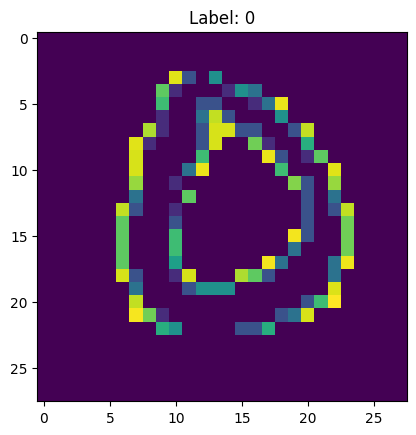

In [7]:
import random
data = random.choice(train_dataset)
label = data[1]
image = data[0]

print('Input size:', image.size())
numpy_img = image.numpy()

plt.imshow(numpy_img.squeeze())
plt.title(f'Label: {label}')
plt.show()

In [41]:
class DigitNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 1)
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 10)         
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        return self.linear_layers(x)

In [42]:
model = DigitNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters())

In [43]:
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    n_elements = 0
    n_correct = 0 

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        n_correct += (y_batch == pred).sum().item()
        n_elements += len(y_batch)


    print(f"Epoch {epoch+1}, total loss: {total_loss}, accuracy: {n_correct/n_elements}")

Epoch 1, total loss: 1512.2525250911713, accuracy: 0.11233333333333333
Epoch 2, total loss: 1511.9175992012024, accuracy: 0.14364285714285716
Epoch 3, total loss: 1511.6369361877441, accuracy: 0.1155
Epoch 4, total loss: 1511.3871870040894, accuracy: 0.11188095238095239
Epoch 5, total loss: 1511.1476650238037, accuracy: 0.11164285714285714
Epoch 6, total loss: 1510.9262330532074, accuracy: 0.11157142857142857
Epoch 7, total loss: 1510.7190072536469, accuracy: 0.11152380952380953
Epoch 8, total loss: 1510.5029802322388, accuracy: 0.11152380952380953
Epoch 9, total loss: 1510.2844455242157, accuracy: 0.11152380952380953
Epoch 10, total loss: 1510.0641572475433, accuracy: 0.11152380952380953
Epoch 11, total loss: 1509.8104708194733, accuracy: 0.11152380952380953
Epoch 12, total loss: 1509.5781331062317, accuracy: 0.11154761904761905
Epoch 13, total loss: 1509.2898395061493, accuracy: 0.11152380952380953
Epoch 14, total loss: 1508.9744942188263, accuracy: 0.11152380952380953
Epoch 15, tota

In [46]:
predictions = []
with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.cpu().numpy())
        
predictions = np.array(predictions)

In [50]:
df_submission = pd.DataFrame({'ImageId': np.array([i+1 for i in range(len(predictions))]), 'Label': predictions})
df_submission.to_csv('./../submissions/digit-recognizer-submission.csv', index=False)

### Score
This approach allowed us to score 0.91 on public :D